### Required activity 25.3: Portfolio project on optimising a model for real-life data

This project aims to predict stock prices using Long Short-Term Memory (LSTM) networks. At the end of the project, we will use Optuna to find the optimal hyperparameters to minimize the loss function.

In [1]:
# pip install pandas_market_calendars

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sb
import datetime
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

now = datetime.now().date()
startdate = now - timedelta(days=365*10) # 10 years

### Part 1. Obtaining a dataset

yfinance offers a threaded and Pythonic way to download market data from Yahoo!Ⓡ finance. 

1. https://github.com/ranaroussi/yfinance


This enable us to download day to day market data when market closes. Some other data that can be downloaded are..

1. dividends 
2. splits
3. capital gains
4. share count
5. income statement
6. quarterly income statement
7. quarterly balance sheet
8. quarterly cashflow
9. major share holders
10. news
11. and more...

Starting from the initial stage, we will be using just Tesla stock's closing price.

In [3]:
# 1. Fetch Historical Stock Prices
tsla = yf.Ticker("TSLA")
tsla_price = tsla.history(start=startdate)
tsla_price.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-05-27 00:00:00-04:00,13.901333,14.258000,13.846667,14.104000,80116500,0.0,0.0
2014-05-28 00:00:00-04:00,14.001333,14.184667,13.684000,14.016000,82426500,0.0,0.0
2014-05-29 00:00:00-04:00,14.038000,14.166000,13.848000,14.016000,55387500,0.0,0.0
2014-05-30 00:00:00-04:00,14.020000,14.320000,13.801333,13.851333,83716500,0.0,0.0
2014-06-02 00:00:00-04:00,13.822000,13.956667,13.444667,13.646667,70021500,0.0,0.0


In [4]:
tsla_price.index = tsla_price.index.strftime('%Y-%m-%d')
tsla_price.index = pd.to_datetime(tsla_price.index)
tsla_price

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-05-27,13.901333,14.258000,13.846667,14.104000,80116500,0.0,0.0
2014-05-28,14.001333,14.184667,13.684000,14.016000,82426500,0.0,0.0
2014-05-29,14.038000,14.166000,13.848000,14.016000,55387500,0.0,0.0
2014-05-30,14.020000,14.320000,13.801333,13.851333,83716500,0.0,0.0
2014-06-02,13.822000,13.956667,13.444667,13.646667,70021500,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-17,173.550003,179.630005,172.750000,177.460007,77445800,0.0,0.0
2024-05-20,177.559998,177.750000,173.520004,174.949997,61727400,0.0,0.0
2024-05-21,175.509995,186.880005,174.710007,186.600006,115266500,0.0,0.0


In [5]:
nasdaq = yf.Ticker("^IXIC")
sp500 = yf.Ticker("^GSPC")

nasdaq_price = nasdaq.history(start=startdate)
sp500_price = sp500.history(start=startdate)

nasdaq_price.index = nasdaq_price.index.strftime('%Y-%m-%d')
nasdaq_price.index = pd.to_datetime(nasdaq_price.index)

sp500_price.index = sp500_price.index.strftime('%Y-%m-%d')
sp500_price.index = pd.to_datetime(sp500_price.index)

tsla_price

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-05-27,13.901333,14.258000,13.846667,14.104000,80116500,0.0,0.0
2014-05-28,14.001333,14.184667,13.684000,14.016000,82426500,0.0,0.0
2014-05-29,14.038000,14.166000,13.848000,14.016000,55387500,0.0,0.0
2014-05-30,14.020000,14.320000,13.801333,13.851333,83716500,0.0,0.0
2014-06-02,13.822000,13.956667,13.444667,13.646667,70021500,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-17,173.550003,179.630005,172.750000,177.460007,77445800,0.0,0.0
2024-05-20,177.559998,177.750000,173.520004,174.949997,61727400,0.0,0.0
2024-05-21,175.509995,186.880005,174.710007,186.600006,115266500,0.0,0.0


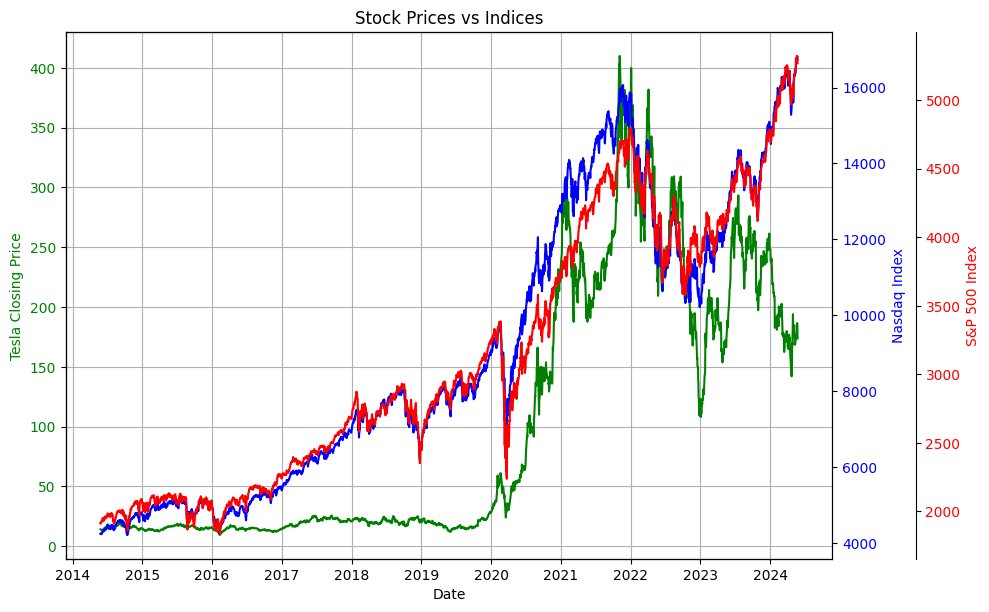

In [6]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(tsla_price['Close'], label='Tesla Closing Price', color='g')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tesla Closing Price', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(nasdaq_price['Close'], label='Nasdaq', color='b')
ax2.set_ylabel('Nasdaq Index', color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(sp500_price['Close'], label='S&P 500', color='r')
ax3.set_ylabel('S&P 500 Index', color='r')
ax3.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Stock Prices vs Indices')
plt.show()

We can see the relationship between this tech stock and the major indices like the S&P 500 and NASDAQ. It's worth noting that TSLA was initially added to the NASDAQ-100 in June 2010 and later added to the S&P 500 on December 21, 2020.

From the plot, the trend was observed to break downward starting in 2023. Could this indicate that a pullback towards a new high coming?

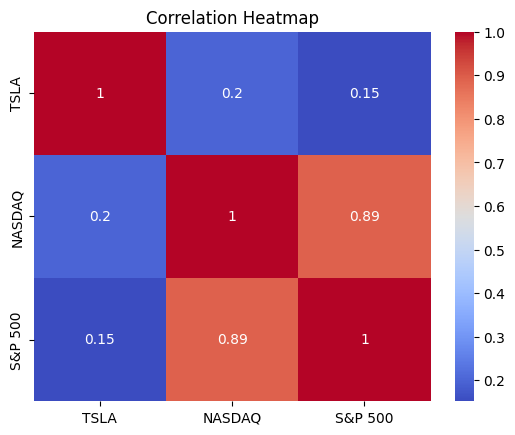

In [7]:
data = pd.DataFrame({
    'TSLA': tsla_price['Close'],
    'NASDAQ': nasdaq_price['Close'],
    'S&P 500': sp500_price['Close']
})

filtered_data = data.loc['2020-12-21':]

correlation = filtered_data.corr(method='spearman')
sb.heatmap(correlation, annot=True, cmap='coolwarm')

# Add titles and labels
plt.title("Correlation Heatmap")
plt.show()

### Part 2. Exploratory Data Analysis (EDA)


It is possible to use multiple features to train LSTM. We can explore what about features can be used.

In [8]:
print(f"Total records are {tsla_price['Close'].shape[0]}."
      f"\nNull check \n{tsla_price.isna().sum()}")

Total records are 2517.
Null check 
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


Other technical indicators and metrics that can help with prediction. 

1. Moving Average Convergence Divergence (MACD) - 
2. Relative Strength Index (RSI) - _Result of stock price_
3. On-Balance Volume (OBV) - _Perhaps doesn't align with short term strategy_
4. Chaikin Money Flow(CMF) - _Perhaps doesn't align with short term strategy_
5. Fibonacci Retracements
6. News Sentiment Analysis
7. and more...

A few consideration for the algorithm are.
1. Not to short a equity (or till model are in higher confidence) to limit potential losses.
2. RSI below 30 should trigger a higher aggressive technical
3. Crossover of MACD line should trigger a higher aggressive technical. Recommended to wait for 3-4 days to confirm __NOT__ a false positive
4. Fibonacci Retracements should support a slightly higher aggressive technical on each level. Most commonly used ratios include 23.6%, 38.2%, 50%, 61.8%, and 78.6

These pointers are what humans can observe. Using deep learning algorithms (RNN-LSTM), more pattern could potentially be uncovered.

In [9]:
#MACD with traditional setting (26/12/9). The signal line is a nine-period EMA of the MACD line.
def compute_macd(tsla_price, short_window=12, long_window=26, signal_window=9):
    data = tsla_price.copy()
    short_ema = tsla_price['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = tsla_price['Close'].ewm(span=long_window, adjust=False).mean()
    
    # MACD line
    data.loc[:, 'MACD'] = short_ema - long_ema
    # Signal Line
    data.loc[:, 'Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return data

df = compute_macd(tsla_price)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal_Line
Date,,,,,,,,,
2014-05-27,13.901333,14.258000,13.846667,14.104000,80116500,0.0,0.0,0.000000,0.000000
2014-05-28,14.001333,14.184667,13.684000,14.016000,82426500,0.0,0.0,-0.007020,-0.001404
2014-05-29,14.038000,14.166000,13.848000,14.016000,55387500,0.0,0.0,-0.012440,-0.003611
2014-05-30,14.020000,14.320000,13.801333,13.851333,83716500,0.0,0.0,-0.029680,-0.008825
2014-06-02,13.822000,13.956667,13.444667,13.646667,70021500,0.0,0.0,-0.059176,-0.018895


In [10]:
#RSI with Exponential Weighted Function(ewm) which give weights to values.
def compute_rsi(tsla_price, window):
    delta = tsla_price.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.ewm(min_periods=window, adjust=False, alpha=1/window).mean()
    avg_loss = loss.ewm(min_periods=window, adjust=False, alpha=1/window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI'] = compute_rsi(tsla_price['Close'], 14)
df.head() # Notice the first 13 rows RSI are NaN due to calculation window

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MACD,Signal_Line,RSI
Date,,,,,,,,,,
2014-05-27,13.901333,14.258000,13.846667,14.104000,80116500,0.0,0.0,0.000000,0.000000,NaN
2014-05-28,14.001333,14.184667,13.684000,14.016000,82426500,0.0,0.0,-0.007020,-0.001404,NaN
2014-05-29,14.038000,14.166000,13.848000,14.016000,55387500,0.0,0.0,-0.012440,-0.003611,NaN
2014-05-30,14.020000,14.320000,13.801333,13.851333,83716500,0.0,0.0,-0.029680,-0.008825,NaN
2014-06-02,13.822000,13.956667,13.444667,13.646667,70021500,0.0,0.0,-0.059176,-0.018895,NaN


In [11]:
naLen = df['RSI'].isna().sum()
naLen

13

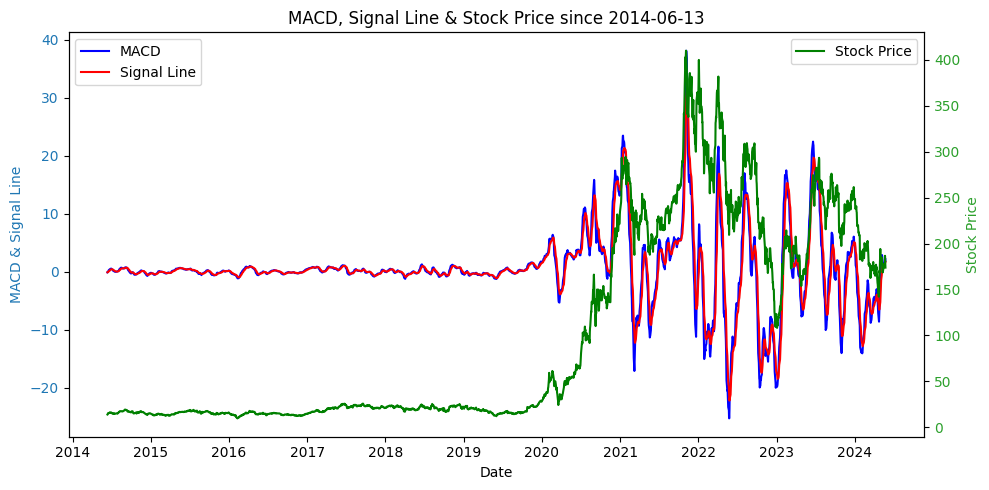

In [12]:
filtered_df = df[naLen:]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('MACD & Signal Line', color='tab:blue')
ax1.plot(filtered_df.index, filtered_df['MACD'], label='MACD', color='blue')
ax1.plot(filtered_df.index, filtered_df['Signal_Line'], label='Signal Line', color='red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
ax2.set_ylabel('Stock Price', color='tab:green')  
ax2.plot(filtered_df.index, filtered_df['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title(f"MACD, Signal Line & Stock Price since {filtered_df.index[0].strftime('%Y-%m-%d')}")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  
plt.show()

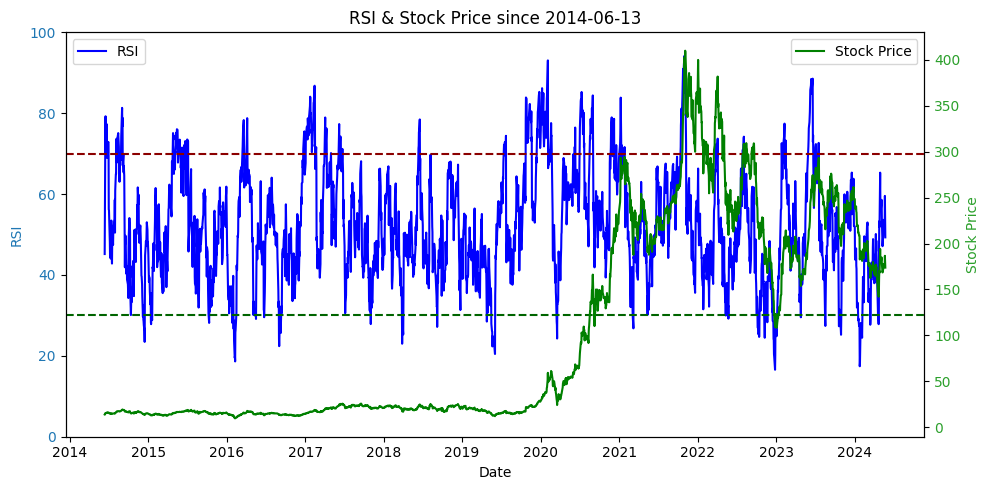

In [13]:
# Plotting RSI and stock price
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('RSI', color='tab:blue')
ax1.plot(filtered_df.index, filtered_df['RSI'], label='RSI', color='blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 100)
ax1.legend(loc='upper left')
ax1.axhline(y=70, color='darkred', linestyle='--')  # Overbought level
ax1.axhline(y=30, color='darkgreen', linestyle='--')  # Oversold level

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Stock Price', color='tab:green')  # we already handled the x-label with ax1
ax2.plot(filtered_df.index, filtered_df['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title(f"RSI & Stock Price since {filtered_df.index[0].strftime('%Y-%m-%d')}")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

In [14]:
print(f"Total records are {filtered_df.shape[0]}."
      f"\nNull check \n{filtered_df.isna().sum()}")

Total records are 2504.
Null check 
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
MACD            0
Signal_Line     0
RSI             0
dtype: int64


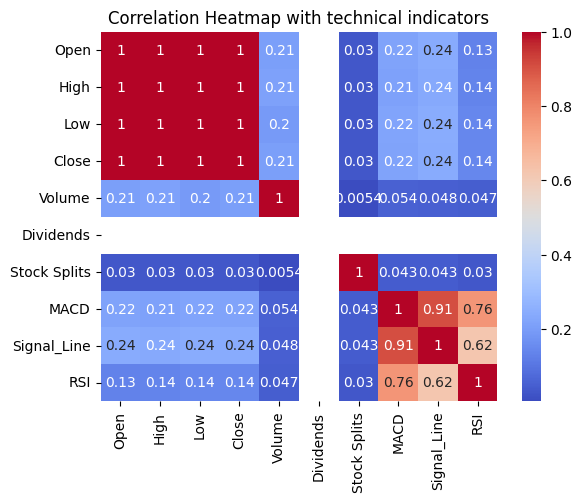

In [15]:
correlation = filtered_df.corr(method='spearman')
sb.heatmap(correlation, annot=True, cmap='coolwarm')

# Add titles and labels
plt.title("Correlation Heatmap with technical indicators")
plt.show()

In [16]:
filtered_df['Dividends'].sum()

0.0

In [17]:
filtered_df = filtered_df.drop(columns='Dividends', axis = 1)
filtered_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Stock Splits', 'MACD',
       'Signal_Line', 'RSI'],
      dtype='object')

We can observe that from the seaborn plot that MACD, Signal Line and RSI are all highly correlated to each other and will impact the model's performance.

For a simple approach, we will be using just the 'Closing' price for LSTM. 

### Part 3. ML techniques and data partition
Recurrent Neural Networks (RNNs) are designed to handle sequences of variable lengths, making them particularly suitable for tasks like predicting future values in a sequence. They maintain an internal state that can capture information about previous elements in the sequence, allowing them to remember important parts and potentially forget less crucial details over time.


However, traditional RNNs suffer from challenges related to the vanishing and exploding gradient problems, especially when processing long sequences. These issues hinder RNN’s ability to learn from distant past information in the sequence.


To address this, __Long Short-Term Memory (LSTM)__ networks were introduced. LSTMs are a special kind of RNN that can learn and remember over long sequences and are not as susceptible to the vanishing gradient problem as standard RNNs. This makes them more efficient at capturing long-term dependencies in sequence data.

Allocation of data for training are
1. Train: 90%
2. Test: 10%

Project is a regression problem, hence we will be testing out performance metrics.
1. Mean Square Error (MSE)

In [18]:
# 2. Preprocess the Data
df = tsla_price[['Close']]

scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(df.values.reshape(-1, 1))

Hyperparameters for the LSTM are: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.01, 'epochs': 100, 'window': 10}
Epoch [50/100], Training loss: 0.0031
Epoch [100/100], Training loss: 0.0018
MSE Test Loss: 0.0030



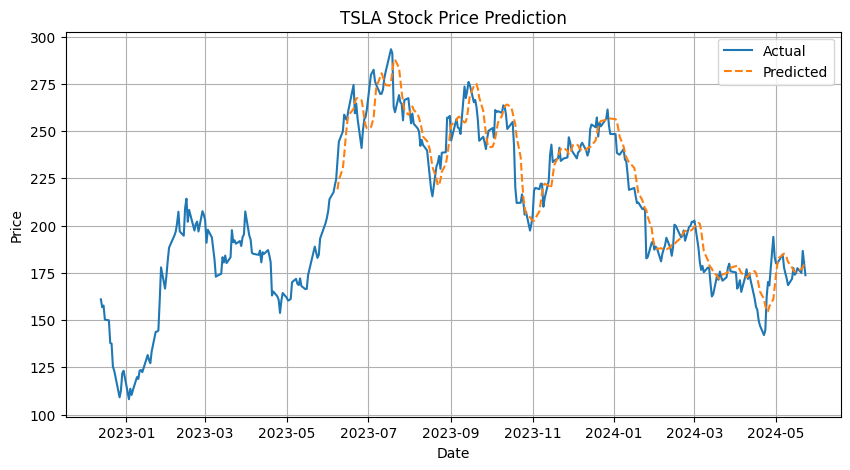

In [19]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

# Prepare data function
def prepare_data(data_normalized, window):
    data_len = len(data_normalized)
    train_ratio = 0.90
    train_len = int(data_len * train_ratio)

    X_train, y_train = [], []
    X_test, y_test = [], []

    # Training data
    for i in range(train_len - window):
        X_train.append(data_normalized[i:i + window])
        y_train.append(data_normalized[i + window])

    # Test data 
    for i in range(train_len, data_len - window):
        X_test.append(data_normalized[i:i + window])
        y_test.append(data_normalized[i + window])

#     print(f"Training Size: {len(X_train)}, Testing Size: {len(X_test)}, Window Size: {window}")
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# Plot prediction against actual data
def plot(tsla_price, predicted_prices, len_test):
    plot_len = int(len_test * 1.5)
    
    plt.figure(figsize=(10, 5))
    plt.plot(tsla_price.index[-plot_len:], tsla_price['Close'].values[-plot_len:], label='Actual')
    plt.plot(tsla_price.index[-len_test:], predicted_prices, label='Predicted', linestyle='dashed')
    
    plt.title('TSLA Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function
def main(X_train, y_train, X_test, y_test, hyperparameters):
    hidden_dim = hyperparameters['hidden_dim']
    num_layers = hyperparameters['num_layers']
    dropout = hyperparameters['dropout']
    learning_rate = hyperparameters['learning_rate']
    epochs = hyperparameters['epochs']
    print(f"Hyperparameters for the LSTM are: {hyperparameters}")

    # Convert numpy arrays to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    
    torch.manual_seed(42)

    # Initialize model
    model = LSTM(input_dim=1, output_dim=1, 
                 hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Training loss: {loss.item():.4f}')

    # Use the last window from the test set to predict the entire test set
    model.eval()
    with torch.no_grad():
        predicted_prices = []
        for i in range(len(X_test)):
            input_data = X_test[i].unsqueeze(0)
            output = model(input_data)
            predicted_prices.append(output.item())
    
    # Convert predicted_prices to a PyTorch tensor and ensure it matches y_test shape
    predicted_prices_tensor = torch.tensor(predicted_prices, dtype=torch.float32).view(-1, 1)
    
    # Compute MSE
    mse_loss = criterion(predicted_prices_tensor, y_test)
    print(f"MSE Test Loss: {mse_loss.item():.4f}\n")

    # Convert predicted_prices to numpy array
    predicted_prices = scaler.inverse_transform(predicted_prices_tensor.numpy().reshape(-1, 1)).flatten()

    return predicted_prices, mse_loss.item(), loss.item(), model

if __name__ == '__main__':
    hyperparameters = {
        'hidden_dim': 128, # LSTM hyperparameter
        'num_layers': 2, # LSTM hyperparameter
        'dropout': 0.2, # LSTM hyperparameter
        'learning_rate': 0.01, # ADAM parameters
        'epochs': 100, # training # ADAM parameters
        'window': 10  # Feature engineering as input config (Data partition)
    }
    
    X_train, y_train, X_test, y_test = prepare_data(data_normalized, hyperparameters['window'])
    predicted_prices, mse_loss, loss, model = main(X_train, y_train, X_test, y_test, hyperparameters)
    
    # Plot prediction
    plot(df, predicted_prices, len(X_test))


Test the initial model

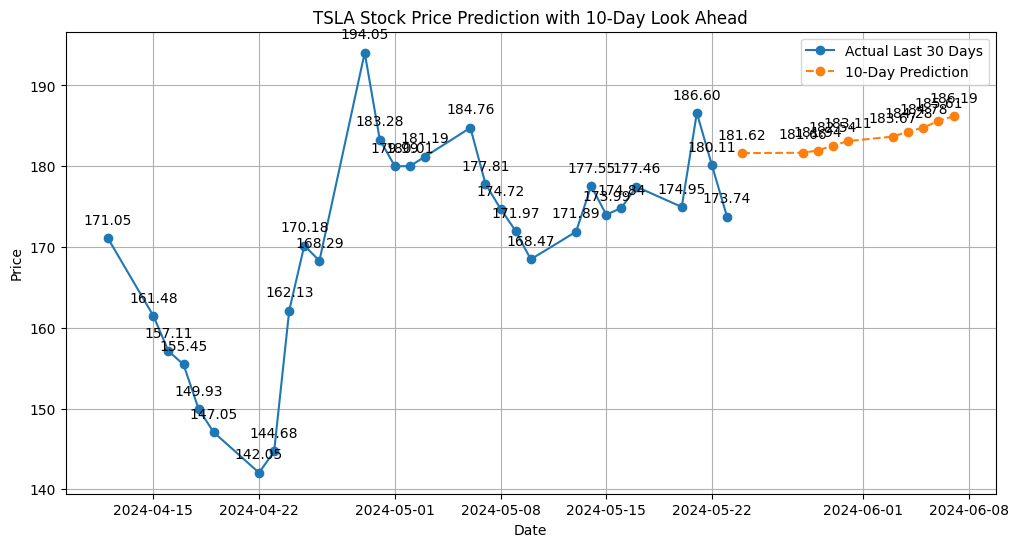

,Date,Predicted
0,2024-05-24 00:00:00+00:00,181.618682
1,2024-05-28 00:00:00+00:00,181.664037
2,2024-05-29 00:00:00+00:00,181.941259
3,2024-05-30 00:00:00+00:00,182.544100
4,2024-05-31 00:00:00+00:00,183.105067
5,2024-06-03 00:00:00+00:00,183.671729
6,2024-06-04 00:00:00+00:00,184.284710
7,2024-06-05 00:00:00+00:00,184.777378
8,2024-06-06 00:00:00+00:00,185.607542
9,2024-06-07 00:00:00+00:00,186.190856


In [20]:
import pandas_market_calendars as mcal

# Function to predict n days ahead
def predict_n_days_ahead(model, data, window, scaler, n_days):
    model.eval()
    with torch.no_grad():
        predictions = []
        input_seq = torch.tensor(data[-window:], dtype=torch.float32).unsqueeze(0)
        for _ in range(n_days):
            output = model(input_seq)
            predictions.append(output.item())
            output = output.view(1, 1, -1)
            input_seq = torch.cat((input_seq[:, 1:, :], output), dim=1)

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Function to plot actual and predicted values for n days
def plot_actual_and_predicted(df, future_predictions, n_days):
    last_n_days_actual = df['Close'].values[-((3*n_days)):]

    # Get the trading calendar for the stock market
    nyse = mcal.get_calendar('NYSE')
    next_trading_days = nyse.valid_days(start_date=df.index[-1], end_date=pd.Timestamp.today() + pd.DateOffset(days=2*n_days))

    date_range_future = next_trading_days[1:n_days+1]
    future_df = pd.DataFrame({'Date': date_range_future, 'Predicted': future_predictions})

    # Plotting the actual and predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-(3*n_days):], last_n_days_actual, label=f'Actual Last {(3*n_days)} Days', marker='o')
    plt.plot(date_range_future, future_predictions, label=f'{n_days}-Day Prediction', linestyle='dashed', marker='o')

    # Annotate actual values
    for i, txt in enumerate(last_n_days_actual):
        plt.annotate(f'{txt:.2f}', (df.index[-(3*n_days) + i], last_n_days_actual[i]), textcoords="offset points", xytext=(0,10), ha='center')

    # Annotate predicted values
    for i, txt in enumerate(future_predictions):
        plt.annotate(f'{txt:.2f}', (date_range_future[i], future_predictions[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title(f'TSLA Stock Price Prediction with {n_days}-Day Look Ahead')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return future_df

# Real testing
n_days = 10  # Change this to any number of days you want to predict
future_predictions = predict_n_days_ahead(model, data_normalized, hyperparameters['window'], scaler, n_days)

future_df = plot_actual_and_predicted(df, future_predictions, n_days)
future_df

### Part 4. Optimize LSTM hyperparameters, training loop parameter and window size

Using Optuna, we can create a study and trial on a objective function of parameters that searches for global minimal. By setting the ranges that we are interested in searching for, Optuna automates the process of tuning which can be time-consuming and complex. Optuna uses Bayesian Optimization to find the best hyperparameters more effectively than random or grid search. This allows for a more efficient search and less computional cost. Optuna is designed to be highly Pythonic, making it easier to integrate and use within Python-based projects like this.

<u>Total of 6 parameters needs optimizing.</u>

LSTM: Hidden Dimensions, Number of Layers, Dropout
Training Loop: Learning rate, epoch
Data Partition: Window

"Window" refers to the size of sliding windows used to create input sequence from the time series data.

For example, data points [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] and a window size of 3.
- [1, 2, 3]
- [2, 3, 4]
- [3, 4, 5]
-     :
- [8, 9, 10]

[I 2024-05-24 16:40:56,594] A new study created in memory with name: no-name-4b08decd-9735-439d-9960-d209f45bcc7c


Hyperparameters for the LSTM are: {'hidden_dim': 176, 'num_layers': 3, 'dropout': 0.34393379242914046, 'learning_rate': 0.00037706061851422944, 'epochs': 270, 'window': 15}
Epoch [50/270], Training loss: 0.0260
Epoch [100/270], Training loss: 0.0047
Epoch [150/270], Training loss: 0.0044
Epoch [200/270], Training loss: 0.0042
Epoch [250/270], Training loss: 0.0039


[I 2024-05-24 16:48:09,965] Trial 0 finished with value: 0.007692981278523803 and parameters: {'hidden_dim': 176, 'num_layers': 3, 'dropout': 0.34393379242914046, 'learning_rate': 0.00037706061851422944, 'epochs': 270, 'window': 15}. Best is trial 0 with value: 0.007692981278523803.


MSE Test Loss: 0.0064

Hyperparameters for the LSTM are: {'hidden_dim': 160, 'num_layers': 3, 'dropout': 0.37817298364457497, 'learning_rate': 0.011822119527029957, 'epochs': 251, 'window': 19}
Epoch [50/251], Training loss: 0.2823
Epoch [100/251], Training loss: 0.2801
Epoch [150/251], Training loss: 0.2801
Epoch [200/251], Training loss: 0.2801
Epoch [250/251], Training loss: 0.2801


[I 2024-05-24 17:29:24,077] Trial 1 finished with value: 0.5733330994844437 and parameters: {'hidden_dim': 160, 'num_layers': 3, 'dropout': 0.37817298364457497, 'learning_rate': 0.011822119527029957, 'epochs': 251, 'window': 19}. Best is trial 0 with value: 0.007692981278523803.


MSE Test Loss: 0.4756

Hyperparameters for the LSTM are: {'hidden_dim': 269, 'num_layers': 3, 'dropout': 0.49057603944349526, 'learning_rate': 0.0006518226593903814, 'epochs': 289, 'window': 5}
Epoch [50/289], Training loss: 0.0096
Epoch [100/289], Training loss: 0.0022
Epoch [150/289], Training loss: 0.0021
Epoch [200/289], Training loss: 0.0021
Epoch [250/289], Training loss: 0.0021


[I 2024-05-24 17:35:44,562] Trial 2 finished with value: 0.004739149357192218 and parameters: {'hidden_dim': 269, 'num_layers': 3, 'dropout': 0.49057603944349526, 'learning_rate': 0.0006518226593903814, 'epochs': 289, 'window': 5}. Best is trial 2 with value: 0.004739149357192218.


MSE Test Loss: 0.0038

Hyperparameters for the LSTM are: {'hidden_dim': 164, 'num_layers': 1, 'dropout': 0.4777654195778034, 'learning_rate': 0.0007692699231015423, 'epochs': 170, 'window': 20}
Epoch [50/170], Training loss: 0.0069
Epoch [100/170], Training loss: 0.0033
Epoch [150/170], Training loss: 0.0031


[I 2024-05-24 17:37:19,233] Trial 3 finished with value: 0.005555501906201243 and parameters: {'hidden_dim': 164, 'num_layers': 1, 'dropout': 0.4777654195778034, 'learning_rate': 0.0007692699231015423, 'epochs': 170, 'window': 20}. Best is trial 2 with value: 0.004739149357192218.


MSE Test Loss: 0.0047

Hyperparameters for the LSTM are: {'hidden_dim': 55, 'num_layers': 2, 'dropout': 0.41902732116227337, 'learning_rate': 0.006151883264806752, 'epochs': 160, 'window': 10}
Epoch [50/160], Training loss: 0.0039
Epoch [100/160], Training loss: 0.0020
Epoch [150/160], Training loss: 0.0015


[I 2024-05-24 17:37:47,516] Trial 4 finished with value: 0.0034596460754983127 and parameters: {'hidden_dim': 55, 'num_layers': 2, 'dropout': 0.41902732116227337, 'learning_rate': 0.006151883264806752, 'epochs': 160, 'window': 10}. Best is trial 4 with value: 0.0034596460754983127.


MSE Test Loss: 0.0028

Hyperparameters for the LSTM are: {'hidden_dim': 245, 'num_layers': 2, 'dropout': 0.17340716717145027, 'learning_rate': 0.022596462328151472, 'epochs': 70, 'window': 7}
Epoch [50/70], Training loss: 0.2775


[I 2024-05-24 17:47:12,034] Trial 5 finished with value: 0.33548590540885925 and parameters: {'hidden_dim': 245, 'num_layers': 2, 'dropout': 0.17340716717145027, 'learning_rate': 0.022596462328151472, 'epochs': 70, 'window': 7}. Best is trial 4 with value: 0.0034596460754983127.


MSE Test Loss: 0.2935

Hyperparameters for the LSTM are: {'hidden_dim': 283, 'num_layers': 2, 'dropout': 0.49932610691211254, 'learning_rate': 0.0003844502557287082, 'epochs': 155, 'window': 5}
Epoch [50/155], Training loss: 0.0070
Epoch [100/155], Training loss: 0.0025
Epoch [150/155], Training loss: 0.0020


[I 2024-05-24 17:49:16,402] Trial 6 finished with value: 0.004540753201581538 and parameters: {'hidden_dim': 283, 'num_layers': 2, 'dropout': 0.49932610691211254, 'learning_rate': 0.0003844502557287082, 'epochs': 155, 'window': 5}. Best is trial 4 with value: 0.0034596460754983127.


MSE Test Loss: 0.0037

Hyperparameters for the LSTM are: {'hidden_dim': 162, 'num_layers': 1, 'dropout': 0.14960532065167542, 'learning_rate': 0.00019339162996225777, 'epochs': 293, 'window': 8}
Epoch [50/293], Training loss: 0.1220
Epoch [100/293], Training loss: 0.0361
Epoch [150/293], Training loss: 0.0085
Epoch [200/293], Training loss: 0.0053
Epoch [250/293], Training loss: 0.0036


[I 2024-05-24 17:50:16,592] Trial 7 finished with value: 0.006900807260535657 and parameters: {'hidden_dim': 162, 'num_layers': 1, 'dropout': 0.14960532065167542, 'learning_rate': 0.00019339162996225777, 'epochs': 293, 'window': 8}. Best is trial 4 with value: 0.0034596460754983127.


MSE Test Loss: 0.0056

Hyperparameters for the LSTM are: {'hidden_dim': 62, 'num_layers': 3, 'dropout': 0.2334434964504508, 'learning_rate': 0.01629432489621917, 'epochs': 198, 'window': 7}
Epoch [50/198], Training loss: 0.0052
Epoch [100/198], Training loss: 0.0037
Epoch [150/198], Training loss: 0.0035


[I 2024-05-24 17:50:57,880] Trial 8 finished with value: 0.007217026315629482 and parameters: {'hidden_dim': 62, 'num_layers': 3, 'dropout': 0.2334434964504508, 'learning_rate': 0.01629432489621917, 'epochs': 198, 'window': 7}. Best is trial 4 with value: 0.0034596460754983127.


MSE Test Loss: 0.0060

Hyperparameters for the LSTM are: {'hidden_dim': 54, 'num_layers': 1, 'dropout': 0.49919437056815674, 'learning_rate': 0.014070110463419242, 'epochs': 118, 'window': 5}
Epoch [50/118], Training loss: 0.0026
Epoch [100/118], Training loss: 0.0016


[I 2024-05-24 17:51:02,531] Trial 9 finished with value: 0.0032021405058912933 and parameters: {'hidden_dim': 54, 'num_layers': 1, 'dropout': 0.49919437056815674, 'learning_rate': 0.014070110463419242, 'epochs': 118, 'window': 5}. Best is trial 9 with value: 0.0032021405058912933.


MSE Test Loss: 0.0026

Hyperparameters for the LSTM are: {'hidden_dim': 101, 'num_layers': 1, 'dropout': 0.28192455286863527, 'learning_rate': 0.07654173636101173, 'epochs': 79, 'window': 13}
Epoch [50/79], Training loss: 0.0040


[I 2024-05-24 17:51:16,586] Trial 10 finished with value: 0.0015709111467003822 and parameters: {'hidden_dim': 101, 'num_layers': 1, 'dropout': 0.28192455286863527, 'learning_rate': 0.07654173636101173, 'epochs': 79, 'window': 13}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0013

Hyperparameters for the LSTM are: {'hidden_dim': 100, 'num_layers': 1, 'dropout': 0.2713749926680563, 'learning_rate': 0.09085063799377716, 'epochs': 71, 'window': 13}
Epoch [50/71], Training loss: 0.0036


[I 2024-05-24 17:51:29,462] Trial 11 finished with value: 0.007829450070858002 and parameters: {'hidden_dim': 100, 'num_layers': 1, 'dropout': 0.2713749926680563, 'learning_rate': 0.09085063799377716, 'epochs': 71, 'window': 13}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0061

Hyperparameters for the LSTM are: {'hidden_dim': 105, 'num_layers': 1, 'dropout': 0.3097366341848317, 'learning_rate': 0.07086658654835992, 'epochs': 112, 'window': 14}
Epoch [50/112], Training loss: 0.0168
Epoch [100/112], Training loss: 0.0011


[I 2024-05-24 17:51:50,516] Trial 12 finished with value: 0.0019741247524507344 and parameters: {'hidden_dim': 105, 'num_layers': 1, 'dropout': 0.3097366341848317, 'learning_rate': 0.07086658654835992, 'epochs': 112, 'window': 14}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0017

Hyperparameters for the LSTM are: {'hidden_dim': 115, 'num_layers': 1, 'dropout': 0.29550637401554597, 'learning_rate': 0.08653404679751324, 'epochs': 110, 'window': 16}
Epoch [50/110], Training loss: 0.0211
Epoch [100/110], Training loss: 0.0026


[I 2024-05-24 17:52:18,023] Trial 13 finished with value: 0.0065629861783236265 and parameters: {'hidden_dim': 115, 'num_layers': 1, 'dropout': 0.29550637401554597, 'learning_rate': 0.08653404679751324, 'epochs': 110, 'window': 16}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0052

Hyperparameters for the LSTM are: {'hidden_dim': 117, 'num_layers': 1, 'dropout': 0.23351012291716283, 'learning_rate': 0.039740220840083954, 'epochs': 109, 'window': 12}
Epoch [50/109], Training loss: 0.0048
Epoch [100/109], Training loss: 0.0018


[I 2024-05-24 17:52:39,661] Trial 14 finished with value: 0.009845088934525847 and parameters: {'hidden_dim': 117, 'num_layers': 1, 'dropout': 0.23351012291716283, 'learning_rate': 0.039740220840083954, 'epochs': 109, 'window': 12}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0050

Hyperparameters for the LSTM are: {'hidden_dim': 202, 'num_layers': 2, 'dropout': 0.34433683647278746, 'learning_rate': 0.0016752793406748958, 'epochs': 55, 'window': 16}
Epoch [50/55], Training loss: 0.0045


[I 2024-05-24 17:53:53,274] Trial 15 finished with value: 0.0050682880682870746 and parameters: {'hidden_dim': 202, 'num_layers': 2, 'dropout': 0.34433683647278746, 'learning_rate': 0.0016752793406748958, 'epochs': 55, 'window': 16}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0045

Hyperparameters for the LSTM are: {'hidden_dim': 87, 'num_layers': 1, 'dropout': 0.21426477306254924, 'learning_rate': 0.040962412520461795, 'epochs': 131, 'window': 13}
Epoch [50/131], Training loss: 0.2820
Epoch [100/131], Training loss: 0.0126


[I 2024-05-24 17:54:13,673] Trial 16 finished with value: 0.015209491364657879 and parameters: {'hidden_dim': 87, 'num_layers': 1, 'dropout': 0.21426477306254924, 'learning_rate': 0.040962412520461795, 'epochs': 131, 'window': 13}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0120

Hyperparameters for the LSTM are: {'hidden_dim': 138, 'num_layers': 2, 'dropout': 0.1166888459124445, 'learning_rate': 0.0057665709105010335, 'epochs': 210, 'window': 11}
Epoch [50/210], Training loss: 0.0031
Epoch [100/210], Training loss: 0.0016
Epoch [150/210], Training loss: 0.0012
Epoch [200/210], Training loss: 0.0011


[I 2024-05-24 17:56:02,321] Trial 17 finished with value: 0.0026892710593529046 and parameters: {'hidden_dim': 138, 'num_layers': 2, 'dropout': 0.1166888459124445, 'learning_rate': 0.0057665709105010335, 'epochs': 210, 'window': 11}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0022

Hyperparameters for the LSTM are: {'hidden_dim': 203, 'num_layers': 1, 'dropout': 0.3363000274076977, 'learning_rate': 0.04544212833852106, 'epochs': 93, 'window': 18}
Epoch [50/93], Training loss: 0.0212


[I 2024-05-24 17:56:57,842] Trial 18 finished with value: 0.010743574472144246 and parameters: {'hidden_dim': 203, 'num_layers': 1, 'dropout': 0.3363000274076977, 'learning_rate': 0.04544212833852106, 'epochs': 93, 'window': 18}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0087

Hyperparameters for the LSTM are: {'hidden_dim': 85, 'num_layers': 1, 'dropout': 0.4196886882754335, 'learning_rate': 0.0033513927938339898, 'epochs': 138, 'window': 14}
Epoch [50/138], Training loss: 0.0034
Epoch [100/138], Training loss: 0.0025


[I 2024-05-24 17:57:19,921] Trial 19 finished with value: 0.0046320827677845955 and parameters: {'hidden_dim': 85, 'num_layers': 1, 'dropout': 0.4196886882754335, 'learning_rate': 0.0033513927938339898, 'epochs': 138, 'window': 14}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0038

Hyperparameters for the LSTM are: {'hidden_dim': 130, 'num_layers': 2, 'dropout': 0.27136615959659066, 'learning_rate': 0.09568492508717184, 'epochs': 87, 'window': 10}
Epoch [50/87], Training loss: 0.3495


[I 2024-05-24 17:59:40,212] Trial 20 finished with value: 0.6776453256607056 and parameters: {'hidden_dim': 130, 'num_layers': 2, 'dropout': 0.27136615959659066, 'learning_rate': 0.09568492508717184, 'epochs': 87, 'window': 10}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.5450

Hyperparameters for the LSTM are: {'hidden_dim': 132, 'num_layers': 2, 'dropout': 0.1002834654574275, 'learning_rate': 0.006465162567011281, 'epochs': 199, 'window': 11}
Epoch [50/199], Training loss: 0.0047
Epoch [100/199], Training loss: 0.0022
Epoch [150/199], Training loss: 0.0016


[I 2024-05-24 18:01:16,430] Trial 21 finished with value: 0.003268727916292846 and parameters: {'hidden_dim': 132, 'num_layers': 2, 'dropout': 0.1002834654574275, 'learning_rate': 0.006465162567011281, 'epochs': 199, 'window': 11}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0026

Hyperparameters for the LSTM are: {'hidden_dim': 138, 'num_layers': 2, 'dropout': 0.13280359365905278, 'learning_rate': 0.026987446344186712, 'epochs': 231, 'window': 11}
Epoch [50/231], Training loss: 0.0225
Epoch [100/231], Training loss: 0.0095
Epoch [150/231], Training loss: 0.0082
Epoch [200/231], Training loss: 0.0030


[I 2024-05-24 18:03:14,137] Trial 22 finished with value: 0.003157651168294251 and parameters: {'hidden_dim': 138, 'num_layers': 2, 'dropout': 0.13280359365905278, 'learning_rate': 0.026987446344186712, 'epochs': 231, 'window': 11}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0026

Hyperparameters for the LSTM are: {'hidden_dim': 83, 'num_layers': 1, 'dropout': 0.3096734507253069, 'learning_rate': 0.007294785157991411, 'epochs': 201, 'window': 17}
Epoch [50/201], Training loss: 0.0069
Epoch [100/201], Training loss: 0.0022
Epoch [150/201], Training loss: 0.0017
Epoch [200/201], Training loss: 0.0015


[I 2024-05-24 18:03:49,830] Trial 23 finished with value: 0.002998466487042606 and parameters: {'hidden_dim': 83, 'num_layers': 1, 'dropout': 0.3096734507253069, 'learning_rate': 0.007294785157991411, 'epochs': 201, 'window': 17}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0025

Hyperparameters for the LSTM are: {'hidden_dim': 104, 'num_layers': 2, 'dropout': 0.20618454515563378, 'learning_rate': 0.0024866204743278957, 'epochs': 223, 'window': 14}
Epoch [50/223], Training loss: 0.0044
Epoch [100/223], Training loss: 0.0027
Epoch [150/223], Training loss: 0.0022
Epoch [200/223], Training loss: 0.0018


[I 2024-05-24 18:05:31,261] Trial 24 finished with value: 0.003836464660707861 and parameters: {'hidden_dim': 104, 'num_layers': 2, 'dropout': 0.20618454515563378, 'learning_rate': 0.0024866204743278957, 'epochs': 223, 'window': 14}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0031

Hyperparameters for the LSTM are: {'hidden_dim': 144, 'num_layers': 1, 'dropout': 0.3988793860636134, 'learning_rate': 0.044827982162277576, 'epochs': 142, 'window': 9}
Epoch [50/142], Training loss: 0.0228
Epoch [100/142], Training loss: 0.0011


[I 2024-05-24 18:05:57,198] Trial 25 finished with value: 0.0017839879728853703 and parameters: {'hidden_dim': 144, 'num_layers': 1, 'dropout': 0.3988793860636134, 'learning_rate': 0.044827982162277576, 'epochs': 142, 'window': 9}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0015

Hyperparameters for the LSTM are: {'hidden_dim': 185, 'num_layers': 1, 'dropout': 0.38937411603947786, 'learning_rate': 0.05635629531359474, 'epochs': 143, 'window': 9}
Epoch [50/143], Training loss: 0.2280
Epoch [100/143], Training loss: 0.0013


[I 2024-05-24 18:06:35,817] Trial 26 finished with value: 0.0018262688536196947 and parameters: {'hidden_dim': 185, 'num_layers': 1, 'dropout': 0.38937411603947786, 'learning_rate': 0.05635629531359474, 'epochs': 143, 'window': 9}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0015

Hyperparameters for the LSTM are: {'hidden_dim': 203, 'num_layers': 1, 'dropout': 0.4101003553955983, 'learning_rate': 0.050626417412225504, 'epochs': 143, 'window': 9}
Epoch [50/143], Training loss: 0.0074
Epoch [100/143], Training loss: 0.0055


[I 2024-05-24 18:07:44,484] Trial 27 finished with value: 0.10847405949607491 and parameters: {'hidden_dim': 203, 'num_layers': 1, 'dropout': 0.4101003553955983, 'learning_rate': 0.050626417412225504, 'epochs': 143, 'window': 9}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0768

Hyperparameters for the LSTM are: {'hidden_dim': 185, 'num_layers': 1, 'dropout': 0.45608034245368484, 'learning_rate': 0.028230102453171174, 'epochs': 183, 'window': 8}
Epoch [50/183], Training loss: 0.2954
Epoch [100/183], Training loss: 0.2782
Epoch [150/183], Training loss: 0.1648


[I 2024-05-24 18:10:22,497] Trial 28 finished with value: 0.0267544137313962 and parameters: {'hidden_dim': 185, 'num_layers': 1, 'dropout': 0.45608034245368484, 'learning_rate': 0.028230102453171174, 'epochs': 183, 'window': 8}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0262

Hyperparameters for the LSTM are: {'hidden_dim': 240, 'num_layers': 1, 'dropout': 0.3800106056973188, 'learning_rate': 0.055237026537872255, 'epochs': 90, 'window': 9}
Epoch [50/90], Training loss: 0.0186


[I 2024-05-24 18:10:56,907] Trial 29 finished with value: 0.007675137370824814 and parameters: {'hidden_dim': 240, 'num_layers': 1, 'dropout': 0.3800106056973188, 'learning_rate': 0.055237026537872255, 'epochs': 90, 'window': 9}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0063

Hyperparameters for the LSTM are: {'hidden_dim': 181, 'num_layers': 1, 'dropout': 0.3702330857362159, 'learning_rate': 0.022525438128513015, 'epochs': 178, 'window': 7}
Epoch [50/178], Training loss: 0.0034
Epoch [100/178], Training loss: 0.0021
Epoch [150/178], Training loss: 0.0018


[I 2024-05-24 18:11:33,998] Trial 30 finished with value: 0.0041619756375439465 and parameters: {'hidden_dim': 181, 'num_layers': 1, 'dropout': 0.3702330857362159, 'learning_rate': 0.022525438128513015, 'epochs': 178, 'window': 7}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0033

Hyperparameters for the LSTM are: {'hidden_dim': 75, 'num_layers': 1, 'dropout': 0.3203033957048596, 'learning_rate': 0.06589937728042042, 'epochs': 123, 'window': 15}
Epoch [50/123], Training loss: 0.0395
Epoch [100/123], Training loss: 0.0010


[I 2024-05-24 18:11:51,607] Trial 31 finished with value: 0.002121782599715516 and parameters: {'hidden_dim': 75, 'num_layers': 1, 'dropout': 0.3203033957048596, 'learning_rate': 0.06589937728042042, 'epochs': 123, 'window': 15}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0017

Hyperparameters for the LSTM are: {'hidden_dim': 150, 'num_layers': 1, 'dropout': 0.36054790941146814, 'learning_rate': 0.03348241146774355, 'epochs': 149, 'window': 12}
Epoch [50/149], Training loss: 0.0083
Epoch [100/149], Training loss: 0.0022


[I 2024-05-24 18:12:33,529] Trial 32 finished with value: 0.003539311233907938 and parameters: {'hidden_dim': 150, 'num_layers': 1, 'dropout': 0.36054790941146814, 'learning_rate': 0.03348241146774355, 'epochs': 149, 'window': 12}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0029

Hyperparameters for the LSTM are: {'hidden_dim': 112, 'num_layers': 1, 'dropout': 0.2830874794145569, 'learning_rate': 0.057948083883191975, 'epochs': 104, 'window': 14}
Epoch [50/104], Training loss: 0.0023
Epoch [100/104], Training loss: 0.0012


[I 2024-05-24 18:12:53,994] Trial 33 finished with value: 0.002180674287956208 and parameters: {'hidden_dim': 112, 'num_layers': 1, 'dropout': 0.2830874794145569, 'learning_rate': 0.057948083883191975, 'epochs': 104, 'window': 14}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0018

Hyperparameters for the LSTM are: {'hidden_dim': 154, 'num_layers': 1, 'dropout': 0.39632869673585547, 'learning_rate': 0.010297138999595033, 'epochs': 50, 'window': 15}


[I 2024-05-24 18:13:10,476] Trial 34 finished with value: 0.00769795966334641 and parameters: {'hidden_dim': 154, 'num_layers': 1, 'dropout': 0.39632869673585547, 'learning_rate': 0.010297138999595033, 'epochs': 50, 'window': 15}. Best is trial 10 with value: 0.0015709111467003822.


Epoch [50/50], Training loss: 0.0047
MSE Test Loss: 0.0067

Hyperparameters for the LSTM are: {'hidden_dim': 177, 'num_layers': 3, 'dropout': 0.44776401992909276, 'learning_rate': 0.07778494697012914, 'epochs': 76, 'window': 12}
Epoch [50/76], Training loss: 0.6091


[I 2024-05-24 18:16:28,036] Trial 35 finished with value: 0.5186392664909363 and parameters: {'hidden_dim': 177, 'num_layers': 3, 'dropout': 0.44776401992909276, 'learning_rate': 0.07778494697012914, 'epochs': 76, 'window': 12}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.4428

Hyperparameters for the LSTM are: {'hidden_dim': 234, 'num_layers': 1, 'dropout': 0.25147483259955633, 'learning_rate': 0.017043114136506814, 'epochs': 165, 'window': 10}
Epoch [50/165], Training loss: 0.2918
Epoch [100/165], Training loss: 0.0357
Epoch [150/165], Training loss: 0.0038


[I 2024-05-24 18:17:36,154] Trial 36 finished with value: 0.11254821717739105 and parameters: {'hidden_dim': 234, 'num_layers': 1, 'dropout': 0.25147483259955633, 'learning_rate': 0.017043114136506814, 'epochs': 165, 'window': 10}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0792

Hyperparameters for the LSTM are: {'hidden_dim': 98, 'num_layers': 1, 'dropout': 0.4482187665912013, 'learning_rate': 0.010135387505106288, 'epochs': 131, 'window': 6}
Epoch [50/131], Training loss: 0.0043
Epoch [100/131], Training loss: 0.0020


[I 2024-05-24 18:17:46,680] Trial 37 finished with value: 0.0039045127923600376 and parameters: {'hidden_dim': 98, 'num_layers': 1, 'dropout': 0.4482187665912013, 'learning_rate': 0.010135387505106288, 'epochs': 131, 'window': 6}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0032

Hyperparameters for the LSTM are: {'hidden_dim': 123, 'num_layers': 1, 'dropout': 0.3320514340588483, 'learning_rate': 0.00011378400689954573, 'epochs': 100, 'window': 9}
Epoch [50/100], Training loss: 0.3430


[I 2024-05-24 18:18:02,767] Trial 38 finished with value: 0.33309172838926315 and parameters: {'hidden_dim': 123, 'num_layers': 1, 'dropout': 0.3320514340588483, 'learning_rate': 0.00011378400689954573, 'epochs': 100, 'window': 9}. Best is trial 10 with value: 0.0015709111467003822.


Epoch [100/100], Training loss: 0.1065
MSE Test Loss: 0.2575

Hyperparameters for the LSTM are: {'hidden_dim': 218, 'num_layers': 2, 'dropout': 0.3520780430511996, 'learning_rate': 0.02032911907797452, 'epochs': 154, 'window': 13}
Epoch [50/154], Training loss: 0.2169
Epoch [100/154], Training loss: 0.0045
Epoch [150/154], Training loss: 0.0024


[I 2024-05-24 18:21:13,699] Trial 39 finished with value: 0.005066891433671117 and parameters: {'hidden_dim': 218, 'num_layers': 2, 'dropout': 0.3520780430511996, 'learning_rate': 0.02032911907797452, 'epochs': 154, 'window': 13}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0042

Hyperparameters for the LSTM are: {'hidden_dim': 169, 'num_layers': 1, 'dropout': 0.390552782115832, 'learning_rate': 0.034576640861033466, 'epochs': 117, 'window': 8}
Epoch [50/117], Training loss: 0.2878
Epoch [100/117], Training loss: 0.2794


[I 2024-05-24 18:23:20,844] Trial 40 finished with value: 0.5936448276042938 and parameters: {'hidden_dim': 169, 'num_layers': 1, 'dropout': 0.390552782115832, 'learning_rate': 0.034576640861033466, 'epochs': 117, 'window': 8}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.4889

Hyperparameters for the LSTM are: {'hidden_dim': 73, 'num_layers': 1, 'dropout': 0.3157749883330733, 'learning_rate': 0.06095408160097183, 'epochs': 120, 'window': 16}
Epoch [50/120], Training loss: 0.0642
Epoch [100/120], Training loss: 0.0072


[I 2024-05-24 18:23:37,970] Trial 41 finished with value: 0.013717639958485961 and parameters: {'hidden_dim': 73, 'num_layers': 1, 'dropout': 0.3157749883330733, 'learning_rate': 0.06095408160097183, 'epochs': 120, 'window': 16}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0114

Hyperparameters for the LSTM are: {'hidden_dim': 71, 'num_layers': 1, 'dropout': 0.32465959414196843, 'learning_rate': 0.07017681487349163, 'epochs': 127, 'window': 15}
Epoch [50/127], Training loss: 0.0967
Epoch [100/127], Training loss: 0.0019


[I 2024-05-24 18:23:56,266] Trial 42 finished with value: 0.0026891237357631326 and parameters: {'hidden_dim': 71, 'num_layers': 1, 'dropout': 0.32465959414196843, 'learning_rate': 0.07017681487349163, 'epochs': 127, 'window': 15}. Best is trial 10 with value: 0.0015709111467003822.


MSE Test Loss: 0.0022

Hyperparameters for the LSTM are: {'hidden_dim': 93, 'num_layers': 1, 'dropout': 0.30421883423153523, 'learning_rate': 0.09832126641750895, 'epochs': 165, 'window': 20}
Epoch [50/165], Training loss: 0.0012
Epoch [100/165], Training loss: 0.0007
Epoch [150/165], Training loss: 0.0142


[I 2024-05-24 18:24:37,631] Trial 43 finished with value: 0.0015027925837785006 and parameters: {'hidden_dim': 93, 'num_layers': 1, 'dropout': 0.30421883423153523, 'learning_rate': 0.09832126641750895, 'epochs': 165, 'window': 20}. Best is trial 43 with value: 0.0015027925837785006.


MSE Test Loss: 0.0014

Hyperparameters for the LSTM are: {'hidden_dim': 149, 'num_layers': 1, 'dropout': 0.2978438809429656, 'learning_rate': 0.09694267931143233, 'epochs': 173, 'window': 20}
Epoch [50/173], Training loss: 0.0816
Epoch [100/173], Training loss: 0.0500
Epoch [150/173], Training loss: 0.0013


[I 2024-05-24 18:25:53,294] Trial 44 finished with value: 0.002788636542391032 and parameters: {'hidden_dim': 149, 'num_layers': 1, 'dropout': 0.2978438809429656, 'learning_rate': 0.09694267931143233, 'epochs': 173, 'window': 20}. Best is trial 43 with value: 0.0015027925837785006.


MSE Test Loss: 0.0022

Hyperparameters for the LSTM are: {'hidden_dim': 94, 'num_layers': 1, 'dropout': 0.2588078159142579, 'learning_rate': 0.000828610734891313, 'epochs': 161, 'window': 19}
Epoch [50/161], Training loss: 0.0509
Epoch [100/161], Training loss: 0.0063
Epoch [150/161], Training loss: 0.0038


[I 2024-05-24 18:26:30,721] Trial 45 finished with value: 0.006497178808785975 and parameters: {'hidden_dim': 94, 'num_layers': 1, 'dropout': 0.2588078159142579, 'learning_rate': 0.000828610734891313, 'epochs': 161, 'window': 19}. Best is trial 43 with value: 0.0015027925837785006.


MSE Test Loss: 0.0056

Hyperparameters for the LSTM are: {'hidden_dim': 113, 'num_layers': 1, 'dropout': 0.1804487514188981, 'learning_rate': 0.0426909749873845, 'epochs': 269, 'window': 18}
Epoch [50/269], Training loss: 0.4125
Epoch [100/269], Training loss: 0.0036
Epoch [150/269], Training loss: 0.0027
Epoch [200/269], Training loss: 0.0018
Epoch [250/269], Training loss: 0.0017


[I 2024-05-24 18:27:40,752] Trial 46 finished with value: 0.0035825209924951196 and parameters: {'hidden_dim': 113, 'num_layers': 1, 'dropout': 0.1804487514188981, 'learning_rate': 0.0426909749873845, 'epochs': 269, 'window': 18}. Best is trial 43 with value: 0.0015027925837785006.


MSE Test Loss: 0.0030

Hyperparameters for the LSTM are: {'hidden_dim': 65, 'num_layers': 3, 'dropout': 0.4269272490885335, 'learning_rate': 0.029476294199347365, 'epochs': 187, 'window': 10}
Epoch [50/187], Training loss: 0.0142
Epoch [100/187], Training loss: 0.0011
Epoch [150/187], Training loss: 0.0008


[I 2024-05-24 18:28:31,820] Trial 47 finished with value: 0.0020940345129929483 and parameters: {'hidden_dim': 65, 'num_layers': 3, 'dropout': 0.4269272490885335, 'learning_rate': 0.029476294199347365, 'epochs': 187, 'window': 10}. Best is trial 43 with value: 0.0015027925837785006.


MSE Test Loss: 0.0017

Hyperparameters for the LSTM are: {'hidden_dim': 191, 'num_layers': 1, 'dropout': 0.24066237999034684, 'learning_rate': 0.07480012796291677, 'epochs': 62, 'window': 6}
Epoch [50/62], Training loss: 0.2803


[I 2024-05-24 18:29:05,734] Trial 48 finished with value: 0.660913422703743 and parameters: {'hidden_dim': 191, 'num_layers': 1, 'dropout': 0.24066237999034684, 'learning_rate': 0.07480012796291677, 'epochs': 62, 'window': 6}. Best is trial 43 with value: 0.0015027925837785006.


MSE Test Loss: 0.5356

Hyperparameters for the LSTM are: {'hidden_dim': 260, 'num_layers': 1, 'dropout': 0.2850795910573396, 'learning_rate': 0.0967175401003907, 'epochs': 140, 'window': 19}
Epoch [50/140], Training loss: 0.2830
Epoch [100/140], Training loss: 0.2823


[I 2024-05-24 18:38:55,369] Trial 49 finished with value: 0.5624014139175415 and parameters: {'hidden_dim': 260, 'num_layers': 1, 'dropout': 0.2850795910573396, 'learning_rate': 0.0967175401003907, 'epochs': 140, 'window': 19}. Best is trial 43 with value: 0.0015027925837785006.


MSE Test Loss: 0.4683

Best hyperparameters found:  {'hidden_dim': 93, 'num_layers': 1, 'dropout': 0.30421883423153523, 'learning_rate': 0.09832126641750895, 'epochs': 165, 'window': 20}
Hyperparameters for the LSTM are: {'hidden_dim': 93, 'num_layers': 1, 'dropout': 0.30421883423153523, 'learning_rate': 0.09832126641750895, 'epochs': 165, 'window': 20}
Epoch [50/165], Training loss: 0.0012
Epoch [100/165], Training loss: 0.0007
Epoch [150/165], Training loss: 0.0142
MSE Test Loss: 0.0014

Model saved to best_model.pth


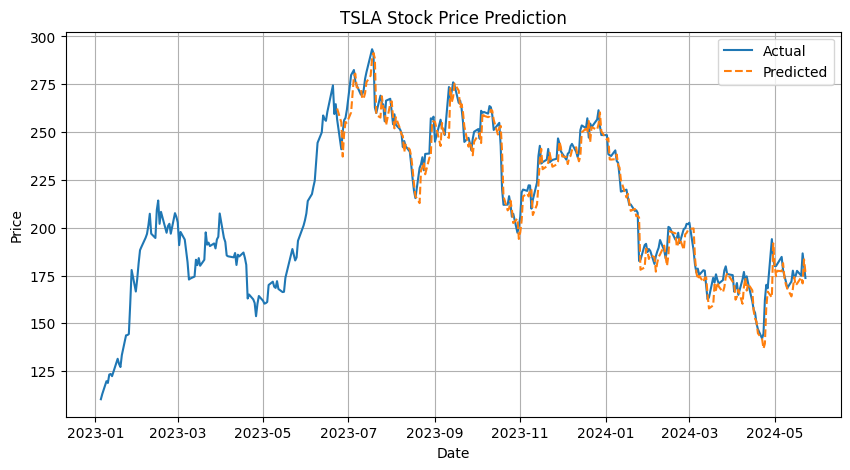

In [21]:
# pip install optuna
import optuna
from optuna.trial import Trial

# Optuna objective function
def objective(trial: Trial):
    hyperparameters = {
        'hidden_dim': trial.suggest_int('hidden_dim', 50, 300),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 50, 300),
        'window': trial.suggest_int('window', 5, 20)
    }

    X_train, y_train, X_test, y_test = prepare_data(data_normalized, hyperparameters['window'])
    predicted_prices, mse_loss, loss, model = main(X_train, y_train, X_test, y_test, hyperparameters)
    
    # Combine training and validation losses to avoid overfitting
    combined_loss = mse_loss + 0.5 * abs(mse_loss - loss)
    
    return combined_loss

# # Run Optuna optimization
# if __name__ == '__main__':
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=50)

#     best_hyperparameters = study.best_params
#     print("Best hyperparameters found: ", best_hyperparameters)

#     # Train the final model with the best hyperparameters
#     X_train, y_train, X_test, y_test = prepare_data(data_normalized, best_hyperparameters['window'])
#     predicted_prices, mse_loss, loss, model = main(X_train, y_train, X_test, y_test, best_hyperparameters)
        
#     # Save the best performing model
#     model_path = 'best_model.pth'
#     torch.save({
#         'model_state_dict': model.state_dict(),
#         'hyperparameters': best_hyperparameters
#     }, model_path)
#     print(f"Model saved to {model_path}")
    
#     # Plot prediction
#     plot(df, predicted_prices, len(X_test))

The best hyperparameters found after 50 trials of Optuna are:

{'hidden_dim': 72, 'num_layers': 1, 'dropout': 0.26041914169823066, 'learning_rate': 0.09859152887190062, 'epochs': 192, 'window': 5}

The model is saved, and the optimization step is commented out to avoid over-writting of saved model. 

In [22]:
# Load the saved state dictionary and hyperparameters
checkpoint = torch.load('best_model.pth')
model_state_dict = checkpoint['model_state_dict']
hyperparameters = checkpoint['hyperparameters']

# Initialize the model with the saved hyperparameters
model = LSTM(input_dim=1, output_dim=1, 
             hidden_dim=hyperparameters['hidden_dim'], 
             num_layers=hyperparameters['num_layers'], 
             dropout=hyperparameters['dropout'])

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)

print("Model and hyperparameters loaded successfully")

Model and hyperparameters loaded successfully


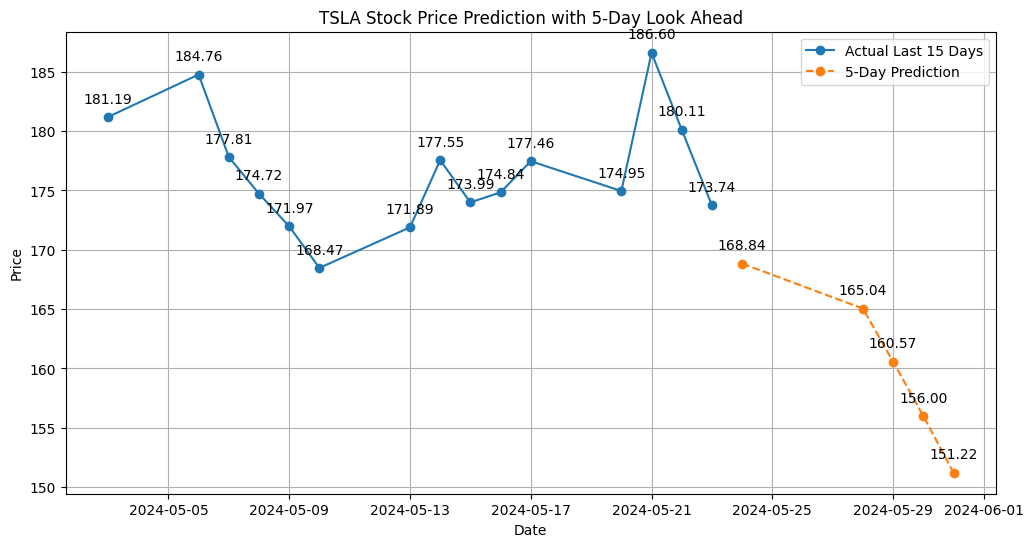

,Date,Predicted
0,2024-05-24 00:00:00+00:00,168.839875
1,2024-05-28 00:00:00+00:00,165.044994
2,2024-05-29 00:00:00+00:00,160.567473
3,2024-05-30 00:00:00+00:00,156.001865
4,2024-05-31 00:00:00+00:00,151.217389


In [26]:
# Function to predict n days ahead
def predict_n_days_ahead(model, data, window, scaler, n_days):
    model.eval()
    with torch.no_grad():
        predictions = []
        input_seq = torch.tensor(data[-window:], dtype=torch.float32).unsqueeze(0)
        for _ in range(n_days):
            output = model(input_seq)
            predictions.append(output.item())
            output = output.view(1, 1, -1)
            input_seq = torch.cat((input_seq[:, 1:, :], output), dim=1)

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Function to plot actual and predicted values for n days
def plot_actual_and_predicted(df, future_predictions, n_days):
    last_n_days_actual = df['Close'].values[-((3*n_days)):]

    # Get the trading calendar for the stock market
    nyse = mcal.get_calendar('NYSE')
    next_trading_days = nyse.valid_days(start_date=df.index[-1], end_date=pd.Timestamp.today() + pd.DateOffset(days=2*n_days))

    date_range_future = next_trading_days[1:n_days+1]
    future_df = pd.DataFrame({'Date': date_range_future, 'Predicted': future_predictions})

    # Plotting the actual and predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-(3*n_days):], last_n_days_actual, label=f'Actual Last {(3*n_days)} Days', marker='o')
    plt.plot(date_range_future, future_predictions, label=f'{n_days}-Day Prediction', linestyle='dashed', marker='o')

    # Annotate actual values
    for i, txt in enumerate(last_n_days_actual):
        plt.annotate(f'{txt:.2f}', (df.index[-(3*n_days) + i], last_n_days_actual[i]), textcoords="offset points", xytext=(0,10), ha='center')

    # Annotate predicted values
    for i, txt in enumerate(future_predictions):
        plt.annotate(f'{txt:.2f}', (date_range_future[i], future_predictions[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title(f'TSLA Stock Price Prediction with {n_days}-Day Look Ahead')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return future_df

# Real testing
n_days = 5  # Change this to any number of days you want to predict
future_predictions = predict_n_days_ahead(model, data_normalized, best_hyperparameters['window'], scaler, n_days)

future_df = plot_actual_and_predicted(df, future_predictions, n_days)
future_df